In [1]:
import glob
import os
import numpy as np
import nibabel as nib
import nobrainer
import numpy as np
from nobrainer.dataset import Dataset
from nobrainer.volume import to_blocks
from utils import label_mapping
from utils.plot_utils import get_color_map, plot_tensor_slices
import matplotlib.pyplot as plt

2024-06-07 08:38:58.282943: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 08:38:58.283041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 08:38:58.283078: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 08:38:58.301275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using label mapping file: /om2/user/hgazula/nobrainer_training_scripts/csv-files/50-class-mapping.csv
Conversion into 50 segmentation classes from freesurfer labels


2024-06-07 08:39:04.854850: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB-LS, pci bus id: 0000:06:00.0, compute capability: 7.0


220 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 21, 26, 28, 30, 44, 47, 49]


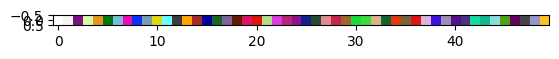

In [2]:
n_classes = 50
label_map = label_mapping.get_label_mapping(n_classes)
labels = sorted(
    glob.glob(os.path.join("/om2/user/hgazula/nobrainer-data/datasets", "*aseg*"))
)

y_true = nib.load(labels[-1]).get_fdata()

u, inv = np.unique(y_true, return_inverse=True)
y_true = np.array([label_map.get(x, 0) for x in u])[inv].reshape(y_true.shape)

blocks = to_blocks(y_true, block_shape=(32, 32, 32))

axis = 0
os.makedirs(f"eval_slice_plots{axis}", exist_ok=True)
cmap = get_color_map(n_classes)
for idx, block in enumerate(blocks):
    if idx != 220:
        continue
    print(idx, list(np.unique(block)))
    fig = plt.figure()
    plt.imshow(np.arange(50)[None], cmap=cmap, interpolation='nearest', vmin=0, vmax= n_classes - 1)
    plt.show()
    break
    # try:
    #     plot_tensor_slices(
    #         block.numpy(),
    #         slice_dim=axis,
    #         cmap=cmap,
    #         out_name=f"eval_slice_plots{axis}/label_{idx:03d}.png",
    #     )
    #     print(f"Plotting block {idx:03d}")
    # except ValueError:
    #     pass

In [3]:
def plot_tensor_slices(
    tensor,
    slice_dim=0,
    cmap="viridis",
    crop_percentile=10,
    out_name=None,
    crop_dims=None,
):
    # # Crop the tensor
    # if not crop_dims:
    #     cropped_tensor, [min_z, max_z, min_x, max_x, min_y, max_y] = crop_tensor(
    #         tensor, percentile=crop_percentile
    #     )
    #     crop_dims = [min_z, max_z, min_x, max_x, min_y, max_y]
    # else:
    #     [min_z, max_z, min_x, max_x, min_y, max_y] = crop_dims
    #     cropped_tensor = tensor[min_z : max_z + 1, min_y : max_y + 1, min_x : max_x + 1]

    cropped_tensor = tensor
    # Determine the dimensions of the cropped tensor
    dim0, dim1, dim2 = cropped_tensor.shape

    fig = plt.figure()
    plt.imshow(np.arange(50)[None], cmap=cmap)
    plt.show()

    # Determine the slicing dimensions based on the specified slice_dim
    if slice_dim == 0:
        num_slices = dim0
        slice_shape = (dim1, dim2)
    elif slice_dim == 1:
        num_slices = dim1
        slice_shape = (dim0, dim2)
    elif slice_dim == 2:
        num_slices = dim2
        slice_shape = (dim0, dim1)
    else:
        raise ValueError("Invalid slice_dim. Must be 0, 1, or 2.")

    # Calculate the grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_slices)))

    # Create a larger matrix to hold the slices
    R = np.zeros((grid_size * slice_shape[0], grid_size * slice_shape[1]))

    # Iterate over the slices and place them in the larger matrix
    for i in range(grid_size):
        for j in range(grid_size):
            slice_index = i * grid_size + j
            if slice_index < num_slices:
                if slice_dim == 0:
                    slice_data = cropped_tensor[slice_index, :, :]
                elif slice_dim == 1:
                    slice_data = cropped_tensor[:, slice_index, :]
                else:  # slice_dim == 2
                    slice_data = cropped_tensor[:, :, slice_index]
                R[
                    i * slice_shape[0] : (i + 1) * slice_shape[0],
                    j * slice_shape[1] : (j + 1) * slice_shape[1],
                ] = slice_data
    # Plot the larger matrix
    # plt.figure(figsize=(10, 10))
    plt.imshow(R, cmap=cmap, interpolation="nearest", vmin=0, vmax=len(cmap.colors) - 1)
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig(out_name, dpi=600)
    plt.show()
    # plt.close()

    return crop_dims, R.astype(np.uint8)

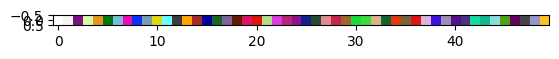

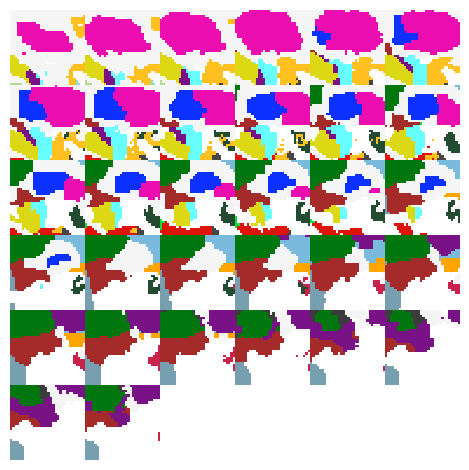

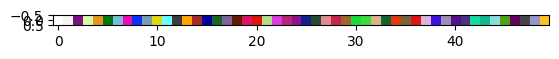

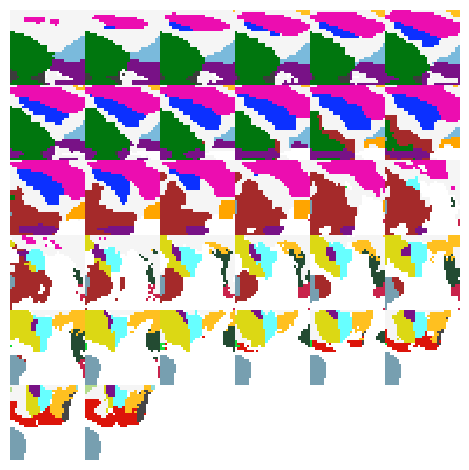

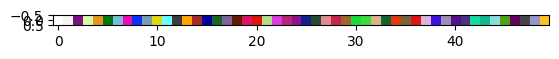

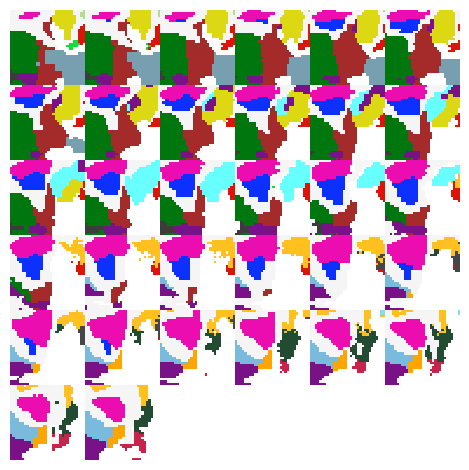

In [5]:
R = plot_tensor_slices(blocks[220], slice_dim=0, cmap=cmap)
R = plot_tensor_slices(blocks[220], slice_dim=1, cmap=cmap)
R = plot_tensor_slices(blocks[220], slice_dim=2, cmap=cmap)